In [1]:
import pints
import pints.toy
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
model = pints.toy.FitzhughNagumoModel()

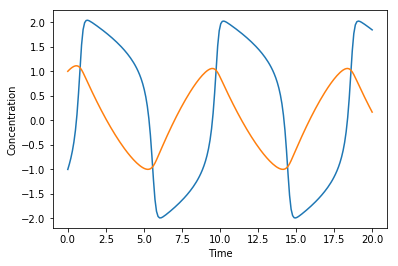

In [2]:
# Run the same simulation using our new model wrapper
times = np.linspace(0, 20, 200)
values = model.simulate([0.1,0.1,3], times)

# Plot the results
plt.figure()
plt.xlabel('Time')
plt.ylabel('Concentration')
plt.plot(times, values)


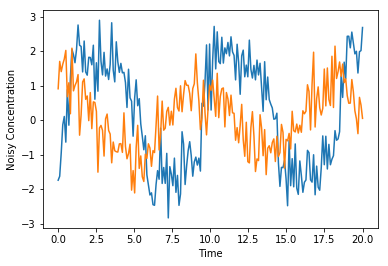

In [3]:
# Define the 'true' parameters
true_parameters = [0.1, 0.1, 3.]

# Run a simulation to get test data
values = model.simulate(true_parameters, times)

# Add some noise
sigma = 0.5
values = values + np.random.randn(values.shape[0],values.shape[1])*sigma

# Plot the results
plt.figure()
plt.xlabel('Time')
plt.ylabel('Noisy Concentration')
plt.plot(times, values)

In [4]:
# Create an object with links to the model and time series
problem = pints.MultiSeriesProblem(model, times, values)

# Select a score function
score = pints.SumOfSquaresError(problem)

Minimising error measure
using Exponential Natural Evolution Strategy (xNES)
Running in sequential mode.
Population size: 7
Iter. Eval. Best      Time m:s
0     7      316.2595   0:00.0
1     14     316.2595   0:00.1
2     21     316.2595   0:00.1
3     28     316.2595   0:00.1
20    147    121.9362   0:00.9
40    287    111.4846   0:02.3
60    427    110.7565   0:03.9
80    567    110.7289   0:05.5
100   707    110.7271   0:07.1
120   847    110.7269   0:08.7
140   987    110.7269   0:10.2
160   1127   110.7269   0:11.8
180   1267   110.7269   0:13.3
200   1407   110.7269   0:14.8
220   1547   110.7269   0:16.3
240   1687   110.7269   0:17.9
260   1827   110.7269   0:19.4
280   1967   110.7269   0:21.0
300   2107   110.7269   0:22.5
320   2247   110.7269   0:24.1
340   2387   110.7269   0:25.6
345   2415   110.7269   0:25.9
Halting: No significant change for 200 iterations.
Score at true solution:
112.32840297
Found solution:          True parameters:
 1.18166598806868847e-01     1.00

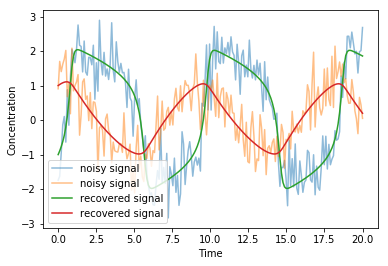

In [6]:
boundaries = pints.Boundaries([0., 0., 0.], [10., 10., 10.])

# Select a starting point
x0 = [1, 1, 1]

# Perform an optimization using SNES (see docs linked above). 
found_parameters, found_value = pints.optimise(score, x0, boundaries=boundaries, method=pints.XNES)
print('Score at true solution:')
print(score(true_parameters))

print('Found solution:          True parameters:' )
for k, x in enumerate(found_parameters):
    print(pints.strfloat(x) + '    ' + pints.strfloat(true_parameters[k]))

# Plot the results
plt.figure()
plt.xlabel('Time')
plt.ylabel('Concentration')
plt.plot(times, values, alpha=0.5, label='noisy signal')
plt.plot(times, problem.evaluate(found_parameters), label='recovered signal')
plt.legend()
plt.show()

In [9]:
log_likelihood = pints.UnknownNoiseLogLikelihood(problem)
log_prior = pints.UniformLogPrior(
    [0, 0, 0, 0],
    [2., 2., 10., 5.]
)
log_posterior = pints.LogPosterior(log_likelihood, log_prior)

In [10]:
found_parameters = np.hstack((found_parameters,sigma))


In [14]:
# Choose starting points for 3 mcmc chains
xs = [
    found_parameters * 1.1,
    found_parameters * 0.9,
    found_parameters * 1.15,
]

# Create mcmc routine
mcmc = pints.MCMCSampling(log_posterior, 3, xs, method=pints.AdaptiveCovarianceMCMC)

# Add stopping criterion
mcmc.set_max_iterations(4000)

# Start adapting after 1000 iterations
mcmc.set_adaptation_free_iterations(1000)

# Disable verbose mode
mcmc.set_log_to_screen(False)

In [20]:
# Run!
print('Running...')
chains = mcmc.run()
print('Done!')


Running...
Done!


In [ ]:
import pints.plot
# Show traces and histograms
pints.plot.trace(chains)

# Discard warm up
chains = chains[:, 500:, :]

# Check convergence using rhat criterion
print('R-hat:')
print(pints.rhat_all_params(chains))

# Look at distribution in chain 0
pints.plot.pairwise(chains[0], kde=True)

# Show graphs
plt.show()

R-hat:
[1.0031620275369899, 1.0000270893348191, 1.0022187927429704, 1.0012563283014297]
